# Deep Learning from the Foundations

These are my notes on [Jeremy Howard's](https://twitter.com/jeremyphoward?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) 
most excellent [Deep Learning from the Foundations](https://course.fast.ai/part2) course. 

These notes are, as Jeremy puts it quite nicely in the course video, _notes for me from six months ago_.

Let's make sure that the requirements for running this notebook are installed. When I wrote this, I'm using `v1.0.60` of 
the `fastai` library. Note that all of the information is contained within the `requirements.txt` file within this repository.

Run the code cell below to see the contents of this file!

In [2]:
import fastai
print(fastai.__version__)

1.0.60


In [4]:
!cat requirements.txt

alembic==1.3.3
async-generator==1.10
attrs==19.3.0
backcall==0.1.0
bleach==3.1.0
blinker==1.4
certifi==2019.11.28
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
cryptography==2.8
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fastai==1.0.60
idna==2.8
importlib-metadata==1.5.0
inflect==4.0.0
ipykernel==5.1.4
ipython==7.11.1
ipython-genutils==0.2.0
ipywidgets==7.5.1
jaraco.itertools==5.0.0
jedi==0.16.0
Jinja2==2.11.0
json5==0.8.5
jsonschema==3.2.0
jupyter-client==5.3.4
jupyter-core==4.6.1
jupyter-telemetry==0.0.4
jupyterhub==1.1.0
jupyterlab==1.2.6
jupyterlab-server==1.0.6
Mako==1.1.0
MarkupSafe==1.1.1
mistune==0.8.4
more-itertools==8.2.0
nbconvert==5.6.1
nbformat==5.0.4
notebook==6.0.3
nteract-on-jupyter==2.1.3
oauthlib==3.0.1
pamela==1.0.0
pandocfilters==1.4.2
parso==0.6.0
pexpect==4.8.0
pickleshare==0.7.5
prometheus-client==0.7.1
prompt-toolkit==3.0.3
ptyprocess==0.6.0
pycparser==2.19
pycurl==7.43.0.5
Pygments==2.5.2
PyJWT==1.7.1
pyOpenSSL==19.1.0
pyrsistent==0.15.7
PySocks==1.7.1
py

There are a bunch of interesting observations that Jeremy is making when looking at the different ecosystems, especially as he 
compares and contrasts between `PyTorch` and `Swift for Tensorflow`.git/

He's still calling out Python's relatively poor performance (certainly compared to Swift). I wonder how much faster it would be 
relative to TorchScript?

## Recreate much of fastai library 

This is the came - recreate much of `fastai` but we can only use:

- python
- python standard library
- non-data science module
- can use PyTorch arrays, RNG, IndexError
- can use fastai.datasets library
- can use matplotlib

So that we can __really__ experiment, understand it by __creating it__, learn the kinds of things that you can __tweak__,
__contribute__ to development and __correlate papers__ with code.

### Some generally helpful resources

- a Wikipedia page that lists [mathematical symbols](https://en.wikipedia.org/wiki/List_of_mathematical_symbols)
- a site that lets you [draw a mathematical symbol](http://detexify.kirelabs.org/classify.html) and it will generate the corresponding TeX notation!

### nbdev

This is the way that Jeremy writes code. It's pretty cool, and he shows off a number of things in this course video.

One thing that I found particularly interesting was how straightforward it is to use [nbformat]() to execute a notebook. 
It is quite literally two lines of code:

``` python
import nbformat    
from nbconvert.preprocessors import ExecutePreprocessor

def run_notebook(path):
    nb = nbformat.fread(open(path), as_version=nbformat.NO_CONVERT)
    ExecutePreprocessor(timeout=600).preprocess(nb, {})
```

He also shows off the way he implements the `#export` command as well. Again, it is very simple, so there really isn't 
much of a reason why we cannot build this kind of functionality into the Azure Notebooks component. All we really need 
to do is run the script below everytime a user executes a cell __successfully__. How hard would that be?

This is all of the code for generating the exported libraries:

``` python
def is_export(cell):
    if cell['cell_type'] != 'code':
        return False
    src = cell['source']
    if len(src) == 0 or len(src[0]) < 7:
        return False
    return re.match(r'^\s*#\s*export\s*$', src[0], re.IGNORECASE) is not None 

def notebook2script(fname):
    fname = Path(fname)
    fname_out = f'nb_{fname.stem.split("_")[0]}.py'
    main_dic = json.load(open(fname, 'r'))
    code_cells = [c for c in main_dic['cells']] if is_export(c)]
    module = f'''
### AUTOGENERATED FILE WARNING ###
'''
    for cell in code_cells: 
        module += ''.join(cell['source'][1:]) + '\n\n'
    module = re.sub(r' +$', '', module, flags=re.MULTILINE)
    open(fname.parent/'exp'/fname_out,'w').write(module[:-2])
```


He also mentions the Python [fire](https://github.com/google/python-fire) library from Google which will automatically convert 
a Python program into a CLI by examining function parameters. It really is very nice, and I wish there were a golang equivalent!

### Roadmap

Trying to create a basic modern CNN model which involves the following sequence of steps:

- matrix multiplication
- RELU/init 
- fully connected network forward step 
- fully connected network backward step 
- Train loop 
- Conv 
- Optim 
- Batch normalization 


## Matrix multiplication 

Now, Jeremy starts doing things using [nbdev](http://nbdev.fast.ai/). I'm going to branch here where I can keep going in the Azure Notebooks
component. But I will also spend some time doing the same thing using JupyterLab so that I can try out the `nbdev` workflow.

Let's get started by writing a cell that imports everything that we are legally allowed to do based on our rules above:

In [7]:
from pathlib import Path
from IPython.core.debugger import set_trace 
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt 
from torch import tensor

Next, let's download and load some matrix data so we can test it using our `matmul` implementation that we will soon write. 
Note that we're using the fastai library's `datasets` library to locate and download our dataset as a gzip file.

In [8]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/jflam/.fastai/data/mnist.pkl.gz')

Use a combination of `gzip` and `pickle` to deserialize the data into a set of `numpy` arrays. 

In [9]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

However, we can't use `numpy` arrays per our rules, so let's convert the data into a PyTorch `tensor` and dump the results of the conversion. 
The code calls `tensor()` against each of the `x_train,y_train,x_valid,y_valid` `numpy` arrays to convert into PyTorch `tensors`:

In [10]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

Now let's plot one of the digits. From above, you can see that each digit in MNIST is actually stored as a PyTorch `torch.FloatTensor` of 
length 784. The [view()](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method from PyTorch lets us easily convert it into a matrix of size (28,28) so that it can
be plotted by `matplotlib`. 

In [25]:
img = x_train[0]
print(img.shape)
z = img.view(28,28)
z.shape

torch.Size([784])


torch.Size([28, 28])

Next, let's plot `z` using `matplotlib`:

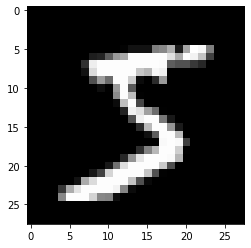

In [26]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(z)


Let's create a simple linear function: $y = ax + b$ where:

- a is a bunch of weights that map our input tenor to our outputs (predicted digits)
- b is our bias which we will initially start with zeroes

In [27]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

Next let's implement a naive matrix multiplication. Note that we have an assert below to ensure that the matrices are of
the right dimensions such that they can be legally multiplied (columns of a == rows of b):

In [28]:
def matmul(a,b):
    ar,ac = a.shape 
    br,bc = b.shape
    assert ac==br 
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]